# Prediction pipeline for test set

In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

import src.feature_processor as fp
import src.model as model
import src.utils as utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load data
train_path = '../data/train.xlsx'
test_path = '../data/test.xlsx'

train_data_raw, test_data_raw = pd.read_excel(train_path), pd.read_excel(test_path)

In [3]:
# Fit and transform training data
# Final run, we feed entire train set to fit the model

feature_processor = fp.FeatureProcessor()

train_processed = feature_processor.fit_transform(train_data_raw)
test_processed = feature_processor.transform(test_data_raw)

nan_counts_train = train_processed.isna().sum()
nan_counts_test = test_processed.isna().sum()
print(f"Total NaN train values: {nan_counts_train.sum()}")
print(f"Total NaN test values: {nan_counts_test.sum()}")

Total NaN train values: 0
Total NaN test values: 0


In [4]:
# Prepare data for model
X_train = train_processed.drop(['quote_id', 'competitor_lowest_price'], axis=1)
y_train = train_processed['competitor_lowest_price']

X_test = test_processed.drop(['quote_id'], axis=1)
quote_ids = test_processed['quote_id']

In [8]:
%%capture

pricing_model = model.PricingModel()
pricing_model.train_base_models(X_train, y_train, X_train, y_train)

In [14]:
pricing_model.base_models[0.7]

In [15]:
# Make prediction with q=0.7 as baseline
y_train_q70 = pricing_model.base_models[0.7].predict(xgb.DMatrix(X_train))
avg_loss_train_q70, market_share_train_q70 = utils.metrics(y_train_q70, y_train)
print(f"Baseline training: avg_loss={avg_loss_train_q70:.2f}, market_share={market_share_train_q70:.2f}")

Baseline training: avg_loss=58.43, market_share=0.30


In [19]:
%%capture
pricing_model.optimizer_params['seed'] = 50
pricing_model.optimizer_params['pop_size'] = 200
pricing_model.optimize_pricing_strategy(X_train, y_train)

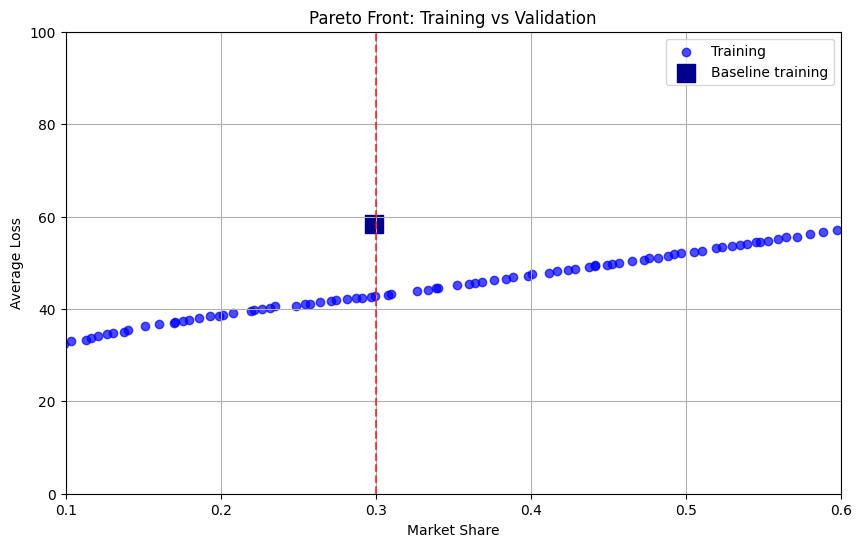

In [39]:
# Plot pareto front to ensure it is smooth
plt.figure(figsize=(10, 6))
plt.scatter(-pricing_model.opti_pricing_results.F[:, 1], pricing_model.opti_pricing_results.F[:, 0], label='Training', alpha=0.7, color='blue')
plt.xlabel('Market Share')
plt.ylabel('Average Loss')
plt.title('Pareto Front: Training vs Validation')
plt.axvline(x=0.3, color='red', linestyle='--', alpha=0.7)
plt.scatter(market_share_train_q70, avg_loss_train_q70, color='darkblue', label='Baseline training', marker='s', s=150)
plt.ylim(0, 100)
plt.xlim(0.1, 0.6)
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Select optimised pricing strategy. We choose 32% as threshold to have a bit of margin w.r.t. 30%

params, market_share, avg_loss = pricing_model.select_optimized_pricing_strategy(market_share_threshold=0.32)
print(f"Market share: {market_share}, Avg loss: {avg_loss}")
for var_name, var_value in zip(model.PricingOptimizationProblem.VAR_NAMES, params):
    print(f"{var_name}: {var_value}")

Market share: 0.32662402909137306, Avg loss: 43.87578974829734
q: 0.14391512821196267
q_high: 0.7146496470139803
q_low: 0.16336408404932057
s_lim: -0.4433166822632224


In [28]:
# Predict test set and set high prices to nan

y_test = pricing_model.predict(X_test)
y_test[y_test > 100000] = np.nan
y_test_df = pd.DataFrame({'quote_id': quote_ids, 'proposed_price': y_test})

# Sanity checks on test set

In [29]:
y_train_opti = pricing_model.predict(X_train)
y_train_opti[y_train_opti > 100000] = np.nan
y_train_opti_df = pd.DataFrame({'quote_id': train_processed['quote_id'], 'proposed_price': y_train_opti})

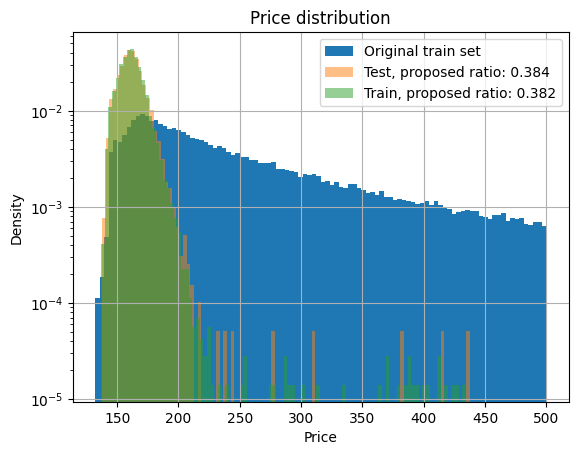

In [34]:
# Predicted distributions are extremely similar

y_test_proposed = y_test_df[y_test_df['proposed_price'].notna()]
y_test_not_proposed = y_test_df[y_test_df['proposed_price'].isna()]
y_train_proposed = y_train_opti_df[y_train_opti_df['proposed_price'].notna()]
y_train_not_proposed = y_train_opti_df[y_train_opti_df['proposed_price'].isna()]

ratio_proposed_test = len(y_test_proposed)/len(y_test_df)
ratio_proposed_train = len(y_train_proposed)/len(y_train_opti_df)

fig, ax = plt.subplots()
y_train.hist(bins=100, ax=ax, label="Original train set", density=True)
y_test_proposed.hist(bins=100, ax=ax, density=True, label=f"Test, proposed ratio: {ratio_proposed_test:.3f}", alpha=0.5)
y_train_proposed.hist(bins=100, ax=ax, density=True, label=f"Train, proposed ratio: {ratio_proposed_train:.3f}", alpha=0.5)
ax.legend()
ax.set_xlabel("Price")
ax.set_ylabel("Density")
ax.set_title("Price distribution")
ax.set_yscale('log')
plt.show()


In [31]:
y_test_df.to_csv('../data/test_evaluation.csv', index=False)

In [32]:
# reload data
y_test_df = pd.read_csv('../data/test_evaluation.csv')


In [33]:
y_test_df.head()

,quote_id,proposed_price
0,18cbee61e6ca9897db10bf97de38d595428b77b42290c9...,NaN
1,e0bab8dadf8d0643c7571a9e6bd125b731adb0121a2a69...,NaN
2,12a965a2ae8b5b432fdf7f3f3b37ed72162f70e5a72798...,165.277128
3,16e839dae5a7defff66e419048036746644afe89b6d984...,NaN
4,a7ce3e8ccd5a5c2b9d774b913b85f6d607f55dc2b21ed1...,163.335603
